In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import seaborn as sns
import pickle
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import rasterio
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import time
import shutil

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working_2"
model_name = "3D_cartes"
exe_name= "../../exe/mf6"

In [3]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer

#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

In [4]:
# load dis infos
top,botm,idomain,delr,delc = read_pickle(os.path.join("working","export_dis3D"))

In [5]:
#spatial parameters

MNT_path = "../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
x0,y0,x1,y1 = rasterio.open(MNT_path).bounds

nlay = idomain.shape[0]
ncol = idomain.shape[2]
nrow = idomain.shape[1]

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid) # instantiate gridintersect object

In [6]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))
                
#uppermost active cell
Up_cells_act = up_act_cell(idomain)

In [7]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True,layer=0)

# attribute a constant head at all the cells in the lst_chd
chd_lst=[];chd_va = 0.1
for x in lst_chd:
    chd_v = -0.025*top[x[1],x[2]] #equivalent freshwater head
    if chd_v < 0:
        chd_v = chd_va
    chd_lst.append((x,chd_v))
    chd_va=chd_v
    #chd_lst.append((x,0.1))

In [8]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True,layer=1)

# attribute a constant head
elev = 0.1; et_drn_lst=[];
for x in etangs_chd:
    et_drn_lst.append((x,elev,1))

In [9]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.003,0.003,0.003,0.003,0.01,0.01]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],1.5)

In [10]:
# Prelevements

geol_col = "NAPPE_CAPT" #name of lithology column
v_col = "VOL_2012" # name of the volume column
path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp" # path to shp
BD = gp.read_file(path)

#remove points with no geometry info
for i in range(BD.shape[0]):
    if BD.geometry[i]==None:
        BD.drop(i,axis=0,inplace=True)
BD  = BD[BD["USAGES"]!="IRRIGATION"]

stress_data_well = importWells3D(BD,grid,lst_domain,fac=1/365/86400,V_col=v_col, geol_col=geol_col,
                                 geol_layer=["PLIOCENE","QUATERNAIRE","INDETERMINE"],layer_num=[[3,4],1,[1,3,4]])

In [11]:
# Prelevements agricoles

path = "../../data/prélèvements/prlvm_agri.asc"
p_agri = rspl_rast(path,grid)

# make a list for rch package
p_agr=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if p_agri[irow,icol] != 0:
        p_agr.append(((icell),p_agri[irow,icol]/1000/365/86400))

In [12]:
# Transmissivity

## plio
T_file ="../../data/T&K/TPlio_mai2018_RGF93_L93_emprise.tif"
T = rspl_rast(T_file,grid)
ep_p = botm[2]-botm[3]
kp=(T/ep_p) # calcul de K
kp[kp>1e-4]=1e-5
kp[kp==0]=1e-5

##q
q_file = "../../data/T&K/TQuat_mai2018_RGF93_L93_emprise.tif"
T_q = rspl_rast(q_file,grid)
ep_q = botm[0]-botm[1]
kq = T_q/ep_q
kq[idomain[1]!=1]=1e-3
kq[kq==0]=1e-5

k = np.ones([nlay,nrow,ncol])*1e-4
k[0] = 1e-5 # Q
k[1] = 1e-3
k[2] = 0.25e-8 # interQ/PC
k[3] = kp #PC
k[4] = 4e-5 # PMS

###### zone sud peu perméable
z1 = [(689e3,616e4),(695e3,616.3e4),(700e3,616.3e4),(700e3,615.2e4),(689e3,615.2e4)]
layer = [1]
kn = 3e-5
k_zones (k,z1,layer,kn,ix)

In [13]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

# Return a 3d array (nlay,nrow,ncol) that can be directly substract with head (each pz is a measure of one cell)

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [14]:
#obs
i,j,c = np.where(Control_Pz!=0)

lst_pts=[]
for o in range(len(i)):
    cell = (i[o],j[o],c[o])
    if cell in lst_domain:
        lst_pts.append(cell)
    
obs_lst1=[]
for pts in lst_pts:
    obs_lst1.append(("{}_{}_{}".format(pts[0],pts[1],pts[2]),"HEAD",pts))

In [15]:
# recharge
rch_path="../../data/recharge/recharge_p.tif"
rch = rspl_rast(rch_path,grid) # resample to grid
rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
rch[idomain[0]==1]=0 # remove some rch
for cell in etangs_chd:
    rch[cell[1],cell[2]]=0
    
rch = liss_mob(rch,5)

# make a list for rch package
rch_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if rch[irow,icol] > 0:
        rch_lst.append(((icell),rch[irow,icol]/1000/365/86400))

#recharge irrigation
irr_path = "../../data/recharge/rast_irr.asc"
irr = rspl_rast(irr_path,grid)
irr[irr<0]=0

# make a list for rch package
irr_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    irr_lst.append(((icell),irr[irow,icol]/1000/365/86400))

In [16]:
## Thuir
layer = [1,3]
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])
plio_chd = []

for layer in layer:
    BDcells = cellidBD(idomain,layer=layer)

    for cellid in ix.intersect_polygon(poly).cellids:
        cell = (layer,cellid[0],cellid[1])
        if cell in BDcells:
            if layer == 1:
                plio_chd.append((cell,140))
            if layer == 3:
                plio_chd.append((cell,115))

In [17]:
# Corbières
layer = [3,4]
Corb_lst = []
flux = 0.2
    
for layer in layer:
    BDcells = cellidBD(idomain,layer) # get boundaries cells
    poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

    res = ix.intersect_polygon(poly)
    for cellid in res.cellids:
        cell = (layer,cellid[0],cellid[1])
        if cell in BDcells:
            Corb_lst.append(cell)
    n_cells = len(Corb_lst)

Corb_spd = []
for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [18]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

obs_recarray = {('heads.csv'):obs_lst1}
obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

# recharge
rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)

# irrigation
irri = fp.mf6.ModflowGwfrch(gwf,pname="irrig",filename="irri.rch",maxbound=len(irr_lst),stress_period_data=irr_lst,save_flows=True)

p_ag = fp.mf6.ModflowGwfrch(gwf,pname="p_agri",filename="p_agri.rch",maxbound=len(p_agr),stress_period_data=p_agr,save_flows=True)


#Corbières
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)

#etangs
etangs = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="eta",filename="eta.drn",maxbound=len(et_drn_lst),
                                              stress_period_data=et_drn_lst,save_flows=True)
#Villeneuve
#Vilnv = fp.mf6.ModflowGwfdrn(gwf,pname="villnv",filename="villnv.drn",maxbound=len(drn_lst),stress_period_data=drn_lst,save_flows=True)

# Rivers
Agly = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,pname="agly",filename="agly.riv",maxbound=len(Agy_chd),
                                                stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [19]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 3D_cartes...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package head_obs...
    writing package npf...
    writing package wel...
    writing package rch...
    writing package irrig...
    writing package p_agri...
    writing package corb...
    writing package sea...
    writing package thuir...
    writing package eta...
    writing package agly...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with 

(True, [])

In [20]:
# retrieve package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

rivfiles=[]
for file in os.listdir(model_dir):
    if file.endswith(".riv"):
        rivfiles.append(os.path.splitext(file)[0])

In [21]:
# piezometers map
pz="../../data/cartes_pz/Pz_Quat_Avril2013_fromProf.grd"
rast = Raster.load(pz)
Mes_pz = rast.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)

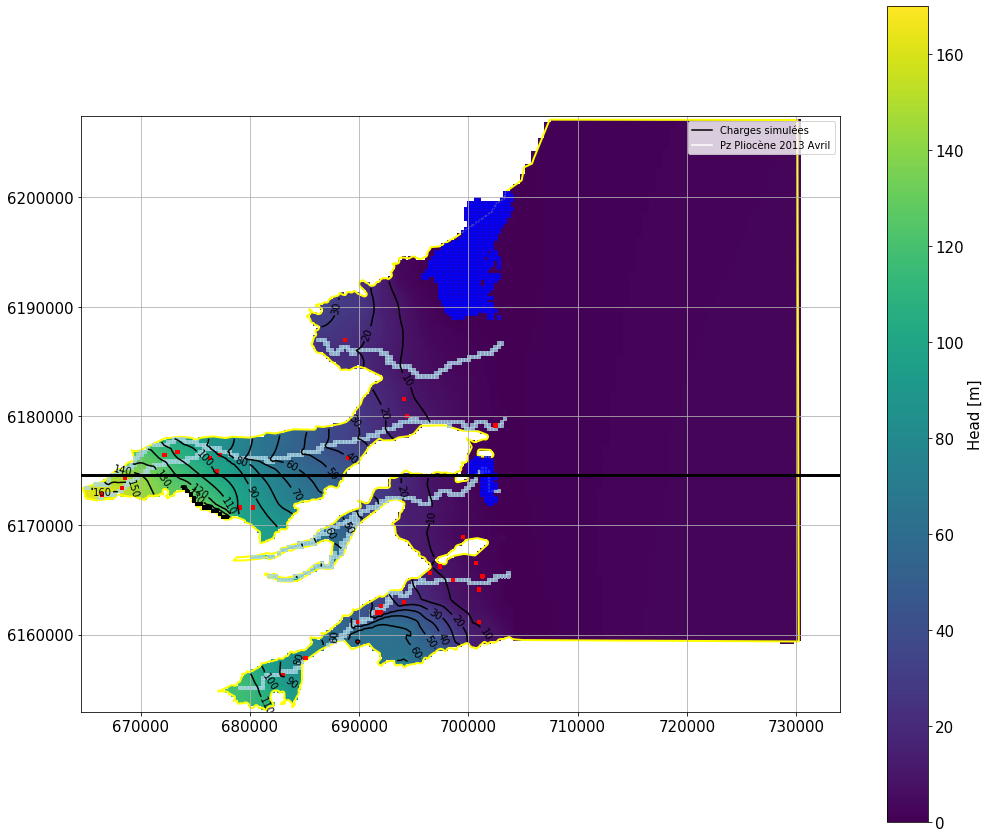

In [22]:
# retrieve heads
head = get_heads(model_name,model_dir)

# initialize plot
fig = plt.figure(figsize=(17,15))
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

#plot heads
hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")

##cont des mesures piézométriques
plot_pz = False
if plot_pz :
    Mes_pz[[head[layer]==1e30]]=None
    cont_2=ml.contour_array(Mes_pz,levels=np.linspace(0,170,18),colors='white')
    plt.clabel(cont_2,fmt="%1i")

#legend
proxy = [plt.Line2D((0,1),(0,0),color="black"),plt.Line2D((0,1),(0,0),color="white")]
plt.legend(proxy,["Charges simulées","Pz Pliocène 2013 Avril"])

fp.plot.plot_shapefile("../../data/shp/entités/Q_ext_2.shp",facecolor="none",edgecolor="yellow",linewidth=2)

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)
for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel")
ml.plot_bc("Corb")
ml.plot_bc("thuir")

# plot Cross-section
row = 110
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)

#
col = 40
x=0
y=0
y = [y0,y1]
x = [x0+(col+.5)*delc[0],x0+(col+.5)*delc[0]]
# ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)

#colorbar
g = plt.colorbar(hmesh)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

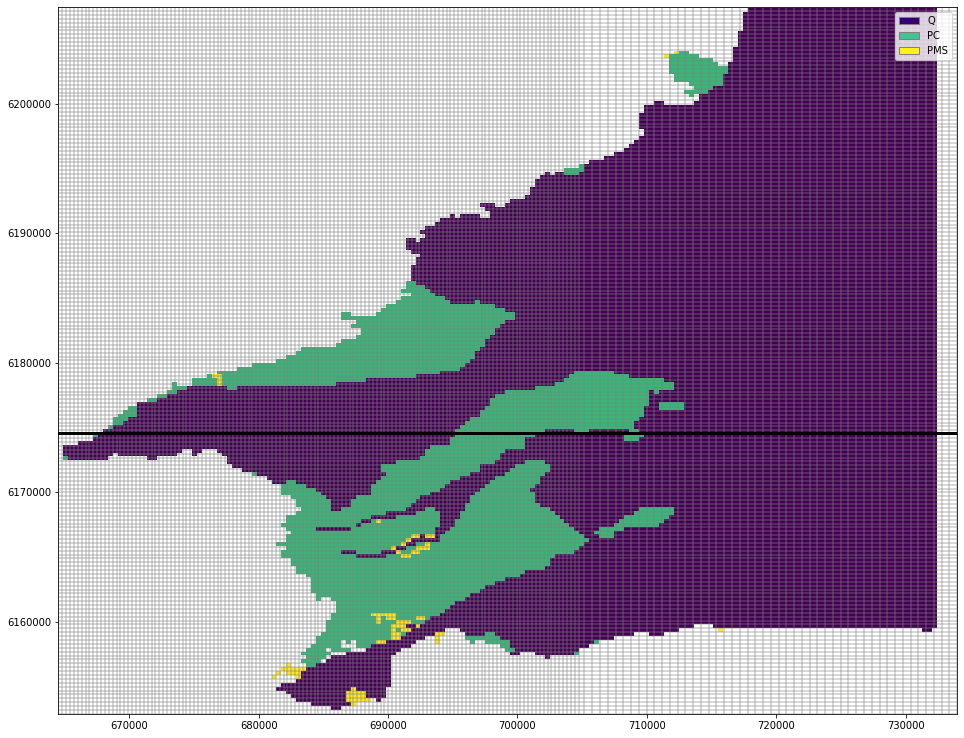

In [23]:
# figures fm
fig,ax = plt.subplots(1,1,figsize=(25,13))
ax.set(aspect="equal")

idomain_p = np.zeros([nrow,ncol])
idomain_p[idomain[1]==1]=1
idomain_p[(idomain[3]==1)&(idomain[1]!=1)]=3
idomain_p[(idomain[4]==1)&(idomain[1]!=1)&(idomain[3]!=1)]=4
idomain_p[idomain_p==0]=None

ax.imshow(idomain_p,extent=(x0,x1,y0,y1))
grid.plot(ax=ax,alpha=0.4)

# plot Cross-section
row = 110
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)

import matplotlib.patches as mpatches
#legend
pQ = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="#340078",alpha=1)
pP = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="#42c392",alpha=1) 
pPm = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="#fdf312",alpha=1) 
proxy = [pQ,pP,pPm]
plt.legend(proxy,["Q","PC","PMS"])

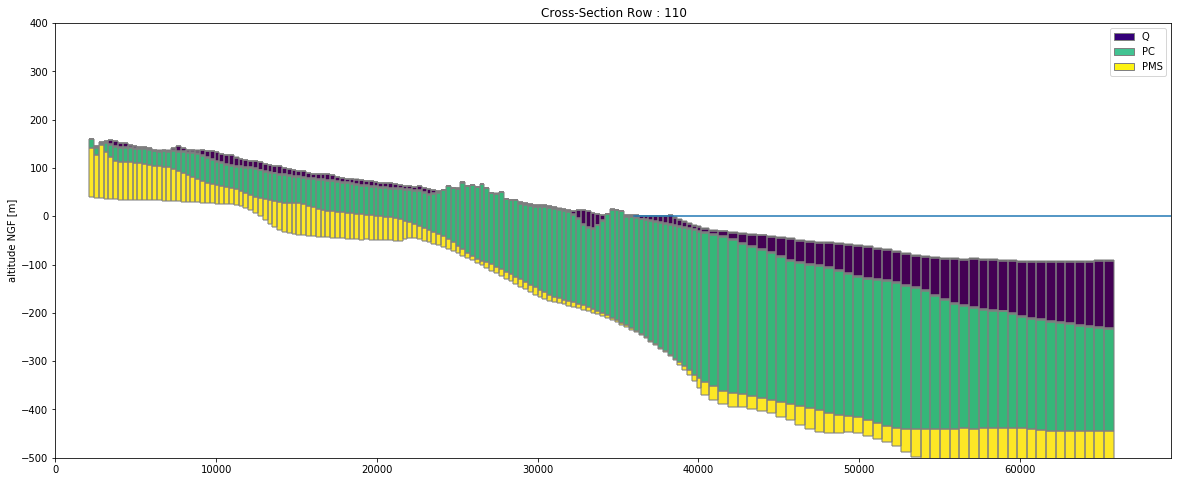

In [31]:
fig,ax = plt.subplots(figsize=(20,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

a = np.array([1,1,2,3,4])
a = a[np.newaxis,np.newaxis,:]
zones = np.ones([nlay,nrow,ncol])*a.T

#arr=x.plot_array(head,masked_values=[1e30],head=head)
arr = x.plot_array(zones) # plot by layers for figures in rapp
#plt.colorbar(arr)
#arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid(alpha=0.7)
#ax.set_xlim(0,65000)
ax.set_ylim(-500,400)
x.plot_bc("sea")

ax.set(ylabel="altitude NGF [m]",title = "Cross-Section Row : {}".format(row))

plt.plot((36000,70000),(0,0))

#legend
pQ = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="#340078",alpha=1)
pP = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="#42c392",alpha=1) 
pPm = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="#fdf312",alpha=1) 
proxy = [pQ,pP,pPm]
plt.legend(proxy,["Q","PC","PMS"])


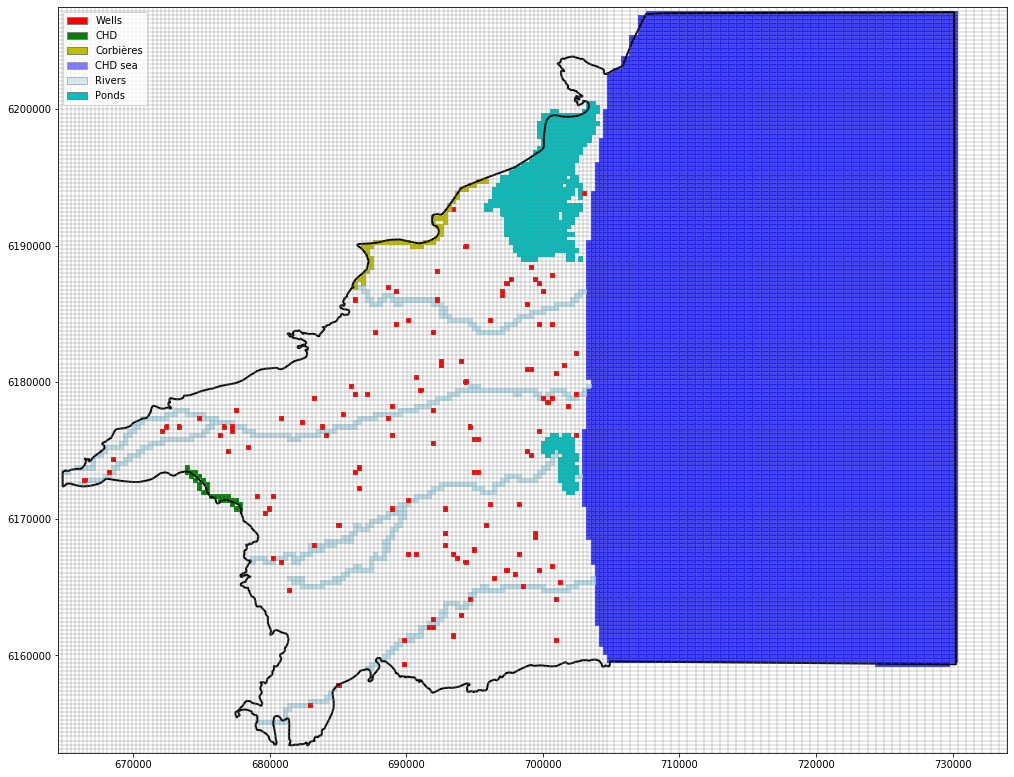

In [33]:
#### PLOT BCs
# initialize plot
fig = plt.figure(figsize=(17,15))
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5,plotAll=True)
for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5,plotAll=True)
ml.plot_bc("eta",color="c",plotAll=True)
ml.plot_bc("wel",plotAll=True)
ml.plot_bc("Corb",color="y",plotAll=True)
ml.plot_bc("thuir",color="g",plotAll=True)

ml.plot_grid(alpha=0.25)

fp.plot.plot_shapefile("../../data/shp/limit_model/limiteModeleRoussillon_poly_offshore_vHydro.shp",facecolor="none",edgecolor="black",linewidth=2)


#legend
wel = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="red",alpha=1)
chd = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="g",alpha=1) 
corb = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="y",alpha=1) 
sea = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="b",alpha=0.5) 
riv = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="lightblue",alpha=0.5) 
eta = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="c",alpha=1) 
proxy = [wel,chd,corb,sea,riv,eta]
plt.legend(proxy,["Wells","CHD","Corbières","CHD sea","Rivers","Ponds"],loc=('upper left'))

Misfit : 4.0167221136616424 m 


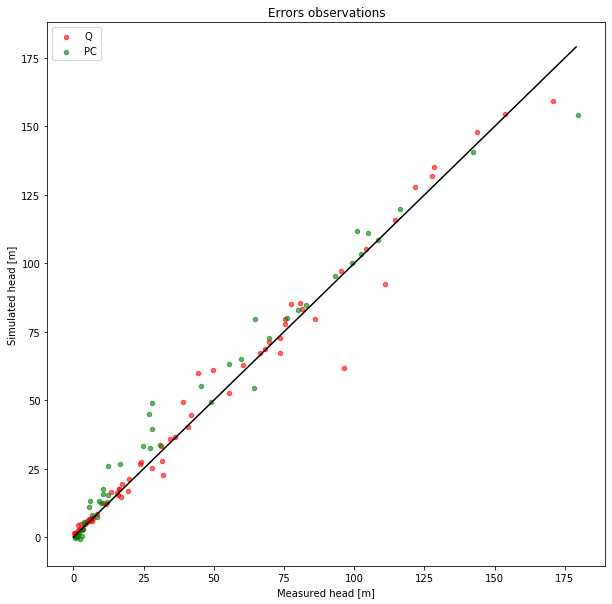

In [26]:
head = get_heads(model_name,model_dir)
color = ["y","red","blue","green","black"]
label = ["sea","Q","inter","PC","PMS"]
fig = plt.figure(figsize=(10,10))

for ilay in [1,3]:
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head_2 = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head_2[Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

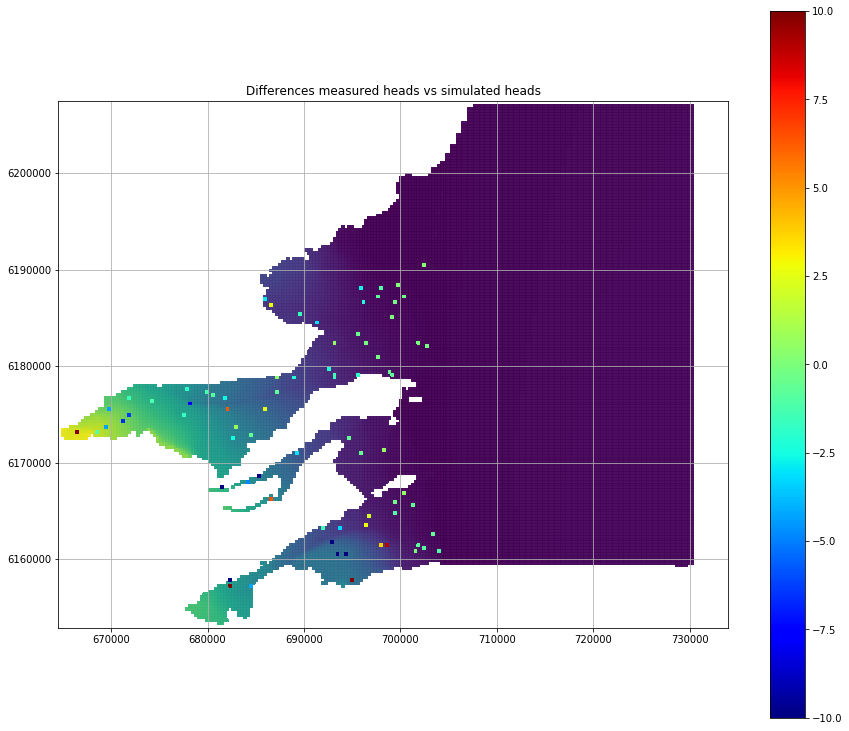

In [27]:
# retrieve heads
head = get_heads(model_name,model_dir)

# initialize plot
fig = plt.figure(figsize=(15,13))
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

back = ml.plot_array(head[layer],masked_values=[1e30],alpha=0.8)
back.set_clim(0,170)

head = head.reshape(nlay*nrow*ncol)
head[Control_pz==0]=None
comp = (Control_pz - head).reshape(nlay,nrow,ncol)
err = ml.plot_array(comp[layer],cmap="jet",vmin=-10,vmax=10)

plt.title("Differences measured heads vs simulated heads")

plt.colorbar(err)
plt.grid()

In [128]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    K = np.ones([nlay,nrow,ncol])
    K[0] = 1e-5
    K[1] = kq
    K[2] = kh[0]
    K[3] = kp
    K[4] = kh[1]

    ###### zone sud peu perméable
    z1 = [(689e3,616e4),(695e3,616.3e4),(700e3,616.3e4),(700e3,615.2e4),(689e3,615.2e4)]
    layer = 1
    kn = 3e-5
    k_zones (k,z1,layer,kn,ix)
    
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=K) # create the new npf package
    npf.write()
    
    
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
        head = head.reshape(nlay*nrow*ncol)
        
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0])))

In [84]:
#minimize(Misfit,[0.25e-8,1e-5],method="Nelder-Mead")

 final_simplex: (array([[2.70436825e-07, 2.66017609e-05],
       [2.33958962e-07, 2.69888725e-05],
       [2.44414520e-07, 2.51234269e-05]]), array([4.47609918, 4.47619309, 4.47619661]))
           fun: 4.4760991765639115
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 31
        status: 0
       success: True
             x: array([2.70436825e-07, 2.66017609e-05])

In [28]:
from Zone_Budget_mf6 import Zb

#create the zones
a = np.array([1,1,2,3,4])
a = a[np.newaxis,np.newaxis,:]
zones = np.ones([nlay,nrow,ncol])*a.T
#zones[idomain==0]=0

#remove some pack cells from zone 1 with ra_pack
#ra_pack(chd,zones,iper=0,value=5)
#ra_pack(Riv2,zones,iper=0,value=6)
#ra_pack(Riv3,zones,iper=0,value=7)

# initiate object
zb = Zb(zones,model_name,model_dir,cbc=get_cbc(model_name,model_dir))

In [29]:
DF_Budg = zb.get_Budget()
np.round(DF_Budg,decimals=2).replace(0,"/")

zone 1       zone 2       zone 3       zone 4      
         FROM    TO   FROM    TO   FROM    TO   FROM    TO
WEL         /  0.44      /     /      /  0.46      /  0.46
CORB        /     /      /     /    0.1     /    0.1     /
ETA         /  0.84      /     /      /     /      /     /
AGLY        /  0.23      /     /      /     /      /     /
TET      0.08  1.52      /     /      /  0.03      /     /
REA      0.12  0.13      /     /   0.03  0.01   0.01     /
CANT     0.04  0.05      /     /   0.07  0.02      /  0.01
TECH     0.12   0.3      /     /      /     /      /  0.01
BOL      0.34  0.04      /     /      /     /      /     /
RCH      2.14     /      /     /   0.98     /   0.02     /
IRRIG    0.52     /      /     /      /     /      /     /
P_AGRI      /  0.49      /     /      /  0.06      /  0.01
SEA      6.02  6.33      /     /      /     /      /     /
THUIR    0.67     /      /     /    0.1  0.01      /     /
zone 1      /     /   0.61  0.92      /  0.01      /     /
zone 2   0.92  0.61      /     /   0.58  0.73   0.03  0.19
zone 3   0.01     /   0.73  0.58      /     /   1.14  0.62
zone 4      /     /   0.19  0.03   0.62  1.14      /     /

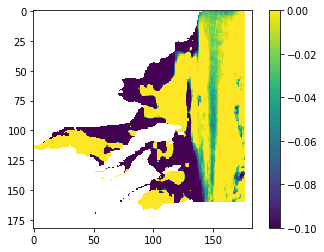

In [30]:
head = get_heads(model_name,model_dir)
head[head>1000]=None
plt.imshow(head[1]-head[3],vmin=-0.1,vmax=0)
plt.colorbar()